# 1. Time Series Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# df['Date'] = pd.to_datetime(df['Date'])

In [2]:
# converting date into index
stock_data = pd.read_csv(r"C:\Users\Acer\Downloads\TSLA.csv",parse_dates=['Date'],index_col='Date')
stock_data.head(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500


In [3]:
stock_data = stock_data.sort_index()
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,3.800000,5.000000,3.508000,4.778000,4.778000,93831500
2010-06-30,5.158000,6.084000,4.660000,4.766000,4.766000,85935500
2010-07-01,5.000000,5.184000,4.054000,4.392000,4.392000,41094000
2010-07-02,4.600000,4.620000,3.742000,3.840000,3.840000,25699000
2010-07-06,4.000000,4.000000,3.166000,3.222000,3.222000,34334500
...,...,...,...,...,...,...
2022-03-18,874.489990,907.849976,867.390015,905.390015,905.390015,33408500
2022-03-21,914.979980,942.849976,907.090027,921.159973,921.159973,27327200
2022-03-22,930.000000,997.859985,921.750000,993.979980,993.979980,35289500


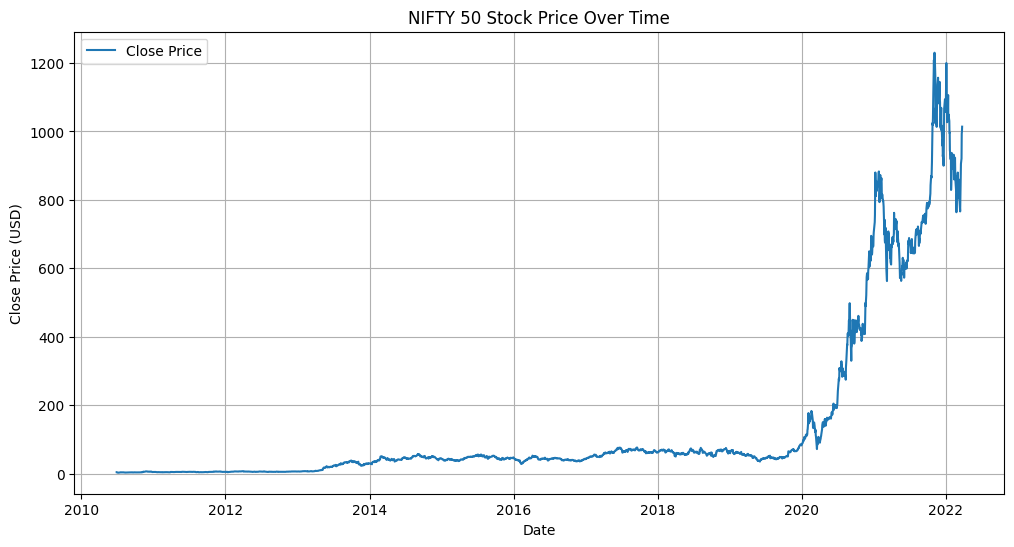

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(stock_data.index, stock_data['Close'],label='Close Price')
plt.title('NIFTY 50 Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid()
plt.show()

# SEASONAL DECOMPOSTION

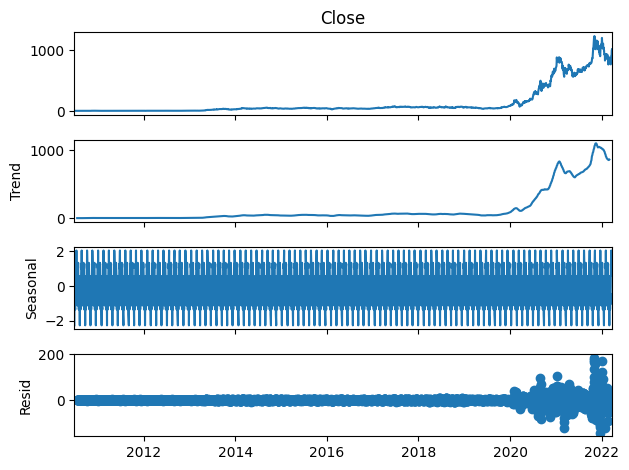

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(stock_data['Close'], model='additive', period=30)
result.plot()
plt.show()

# Stationarity Test

In [6]:
# stationary means mean, median & Constant overtime

In [7]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(stock_data['Close'])
print('ADF Test Results')
print(f'ADF Statsitic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')
print('critical values:')
adf_test[4]

ADF Test Results
ADF Statsitic: 1.4239415939225948
p-value: 0.9972202364261444
critical values:


{'1%': -3.4325860929804404,
 '5%': -2.8625279573644873,
 '10%': -2.5672959172141048}

In [8]:
0.6339836109744442 < 0.05

# It is non stationary data

False

# Making Data Stationary

In [9]:
stock_diff = stock_data['Close'].diff().dropna()

In [10]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(stock_diff)
print('ADF Test Results')
print(f'ADF Statsitic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')
print('critical values:')
adf_test[4]

ADF Test Results
ADF Statsitic: -9.84495533948486
p-value: 4.646088212092244e-17
critical values:


{'1%': -3.432586857867417, '5%': -2.862528295182304, '10%': -2.567296097065506}

In [11]:
0.0 < 0.05

True

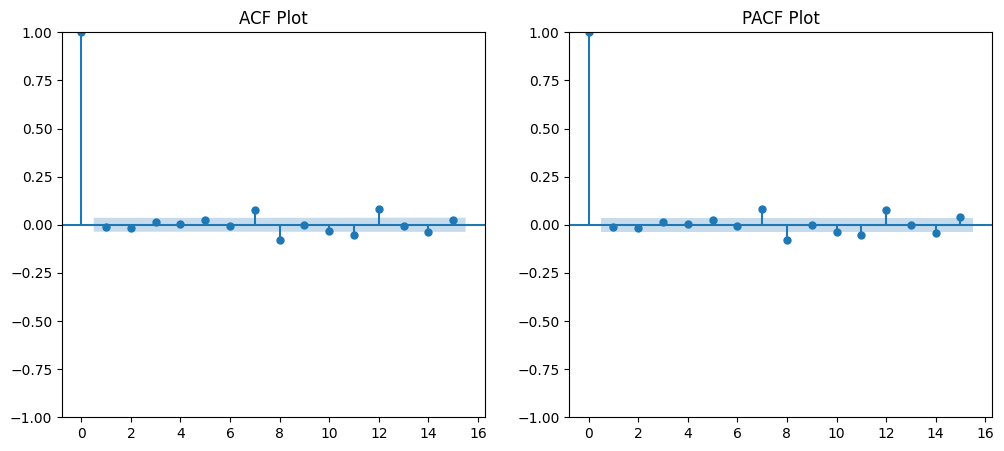

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(stock_diff, lags=15, ax=axes[0])
plot_pacf(stock_diff, lags=15, method='ywm', ax=axes[1])
axes[0].set_title("ACF Plot")
axes[1].set_title("PACF Plot")
plt.show()

# Train test split

In [13]:
# 80-20 split (common practice):
train_size = int(len(stock_data) * 0.8)
train, test = stock_data[:train_size], stock_data[train_size:]

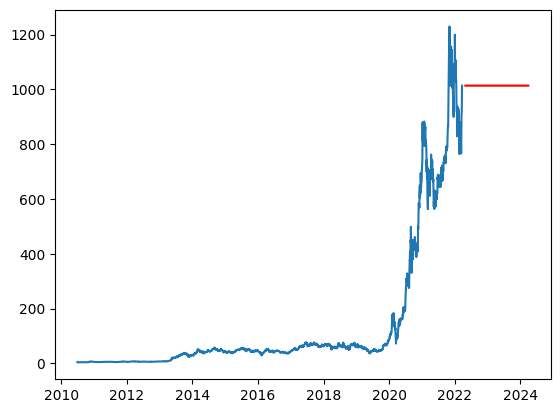

In [23]:
model = sm.tsa.ARIMA(stock_data['Close'], order=(1, 1, 1))
result = model.fit()

forecast = result.get_forecast(steps=24)
forecast_index = pd.date_range(stock_data.index[-1], periods=25, freq='M')[1:]

plt.plot(stock_data.index, stock_data['Close'])
plt.plot(forecast_index, forecast.predicted_mean, 'r')
plt.show()


In [32]:
forecast_values = forecast.predicted_mean
rmse = np.sqrt(mean_squared_error(test['Close'], forecast_values))
print(f"RMSE: {rmse:.4f}")

RMSE: 573.4603


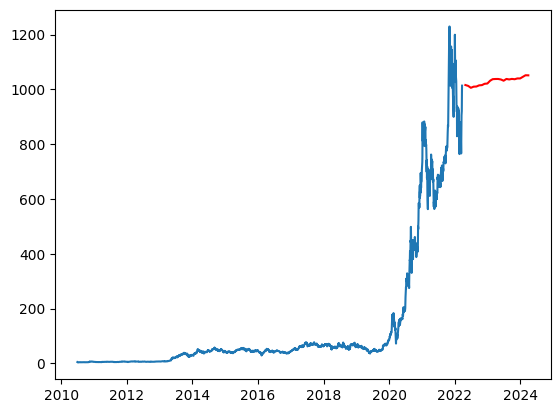

In [15]:
model = sm.tsa.statespace.SARIMAX(stock_data['Close'], order=(1,1,1), seasonal_order=(1,1,1,12))
result = model.fit()
# print(sarima_result.summary())

forecast = result.get_forecast(steps=24)
forecast_index = pd.date_range(stock_data.index[-1], periods=25, freq='M')[1:]

plt.plot(stock_data.index, stock_data['Close'])
plt.plot(forecast_index, forecast.predicted_mean, 'r')
plt.show()


# Note: step 24 means 2 year. and jitne year ki value hogi periods ko +1 rkna hai

Importing plotly failed. Interactive plots will not work.
17:11:22 - cmdstanpy - INFO - Chain [1] start processing
17:11:24 - cmdstanpy - INFO - Chain [1] done processing


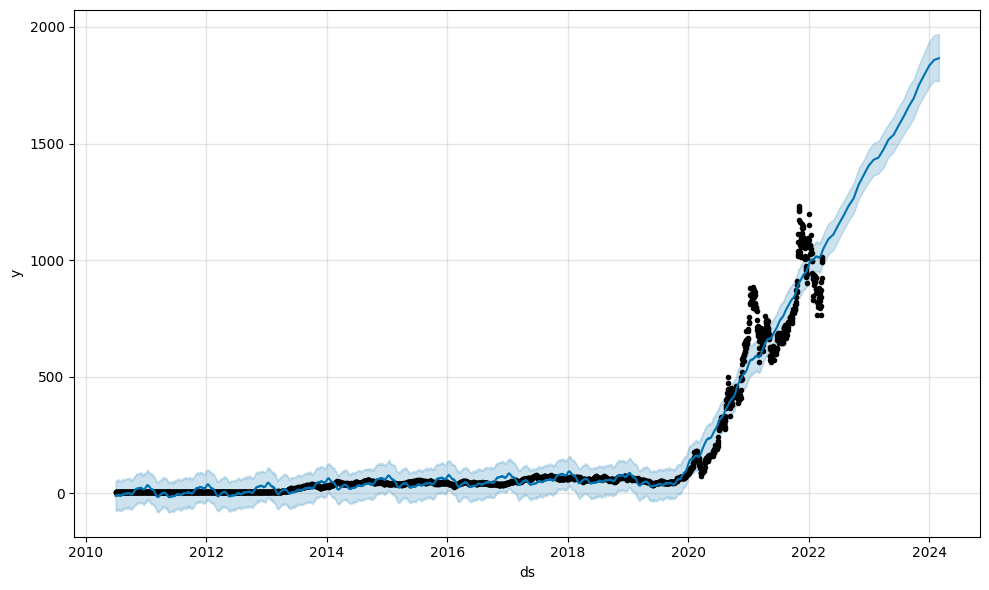

In [16]:
from prophet import Prophet
import matplotlib.pyplot as plt
import pandas as pd

# Prophet ke liye data rename krna padta hai
df = stock_data.reset_index()[['Date', 'Close']]
df.columns = ['ds', 'y']

model = Prophet()
model.fit(df)

future = model.make_future_dataframe(periods=24, freq='M')
forecast = model.predict(future)

# Plot
model.plot(forecast)
plt.show()
